In [2]:
import pandas as pd
import numpy as np
 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#sns.set(style="darkgrid")
#import bayespy 

import pymc3 as pm
import arviz as az
import theano.tensor as tt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import ks_2samp

# pd.set_option('display.max_columns', None)

from utils import *

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

#%load_ext watermark
#%watermark -dtmvgp numpy,scipy,matplotlib,pandas,seaborn,pymc3,theano,arviz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
path = 'data/tv_dig.csv'
data = pd.read_csv(path)

In [4]:
data.head()

,DIG_IMPS,TV_IMPS,TOTAL_CONV
0,0.0,1.0,6
1,0.0,1.0,4
2,0.0,8.0,0
3,0.0,10.0,6
4,0.0,6.0,0


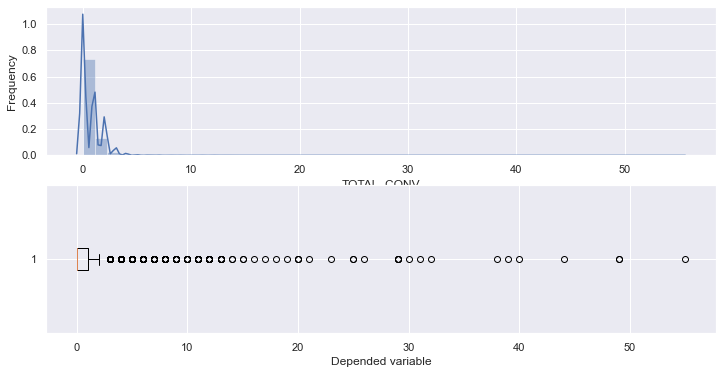

In [5]:
target_distribution(data.TOTAL_CONV)

In [6]:
# data = data[data.TOTAL_CONV != 0]
data = data[(data.TOTAL_CONV<20)] # & (data.TOTAL_CONV!=0)

In [7]:
x = data[[col for col in data.columns if col != 'TOTAL_CONV']].values
y = data.TOTAL_CONV.values

### GLM

In [11]:
# specifying priors and formula
formula = 'TOTAL_CONV ~ ' + ' + '.join(['%s' % variable for variable in data.columns[:-1]])

In [12]:
d_coef = {}
for val in data.columns[:-1]:
    d_coef[val] = d_coef.get(val, pm.HalfNormal.dist())

d_intercept = {'Intercept': pm.Normal.dist()}

# combining priors
d_priors = {**d_intercept,**d_coef}

In [21]:
# Context for the model
with pm.Model() as model_glm_nb:
    
    family = pm.glm.families.NegativeBinomial()
    pm.GLM.from_formula(formula,
                        data = data, 
                        family= family)
    
    trace_glm_nb = pm.sample(chains = 4, target_accept = 0.9)

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [alpha, mu, TV_IMPS, DIG_IMPS, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1090 seconds.


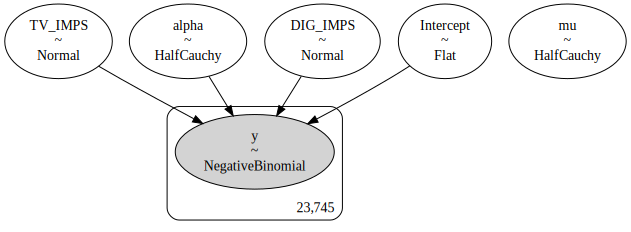

In [22]:
pm.model_to_graphviz(model_glm_nb)

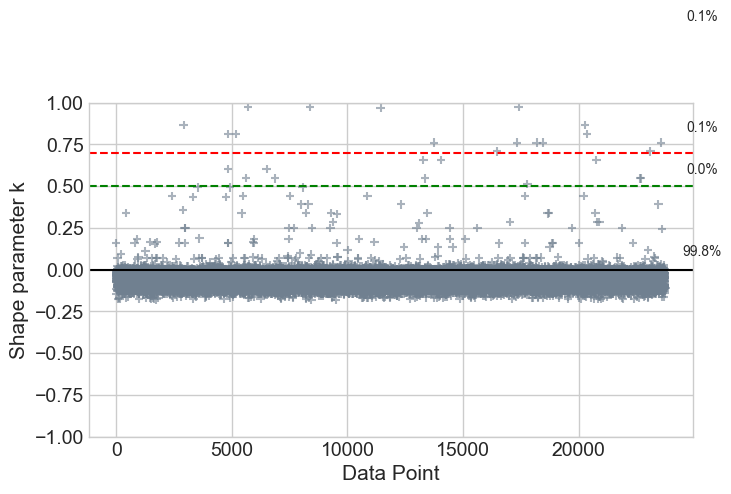

In [25]:
# compute with arviz InferenceData type
p_loo_zinb = pm.loo(trace_glm_nb, pointwise=True, var_name='y')

# plot khat diagnostic
plt.style.use("arviz-whitegrid")
pm.plot_khat(p_loo_zinb, show_bins=True, color='slategray', alpha=0.6)
plt.axhline(0.5, color = 'green', linestyle='dashed')
plt.axhline(0.7, color = 'red', linestyle='dashed')
plt.axhline(0, color='black')
plt.ylim((-1, 1))
plt.show()

In [26]:
ppc = pm.sample_posterior_predictive(trace_glm_nb, model=model_glm_nb, samples =200)

In [27]:
az.r2_score(y, ppc['y'])

r2        0.097208
r2_std    0.056770
dtype: float64

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'DIG_IMPS'}>,
        <AxesSubplot:title={'center':'DIG_IMPS'}>],
       [<AxesSubplot:title={'center':'TV_IMPS'}>,
        <AxesSubplot:title={'center':'TV_IMPS'}>],
       [<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>]], dtype=object)

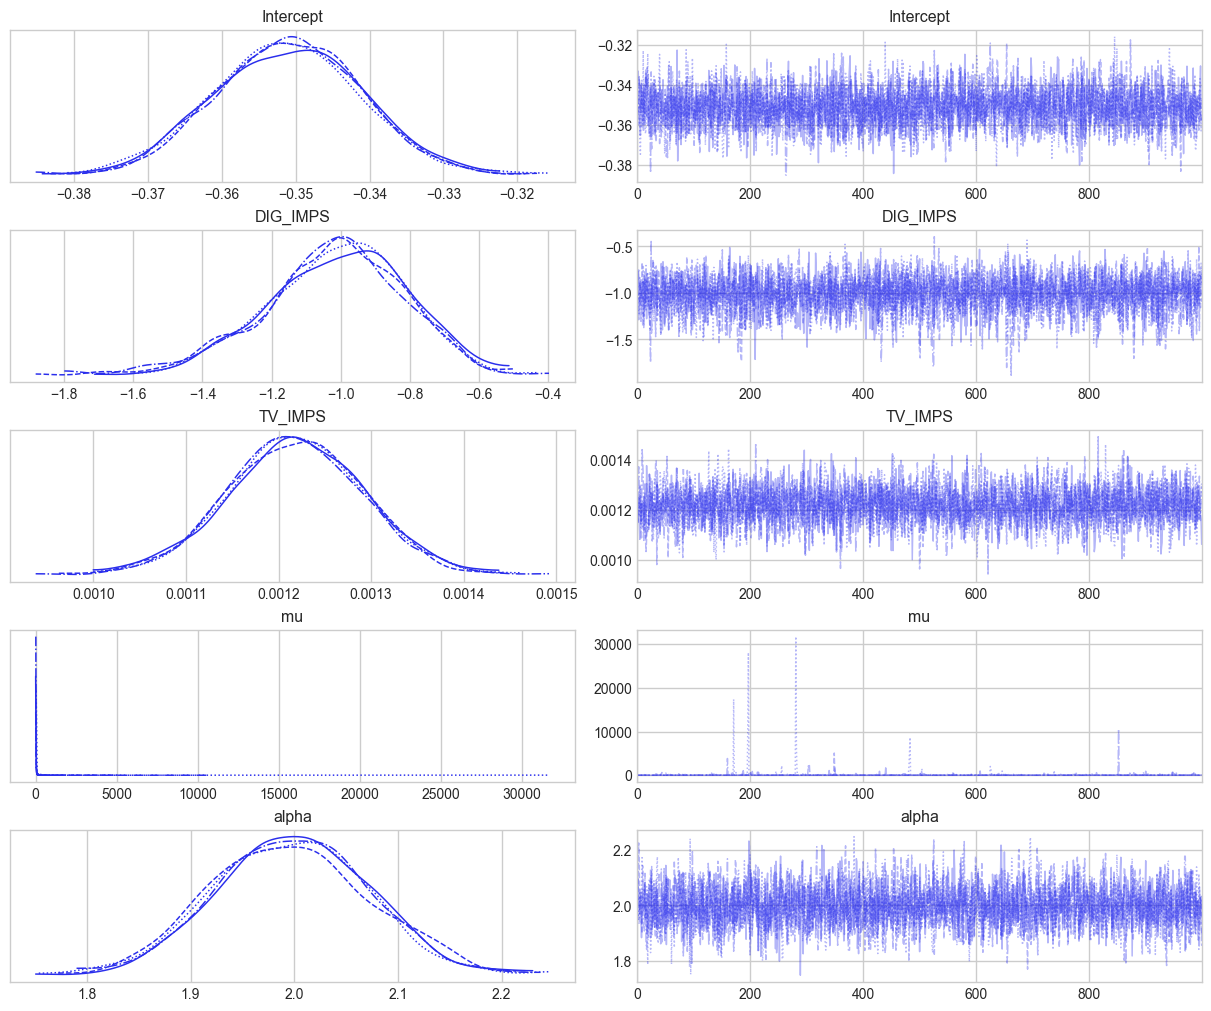

In [28]:
az.plot_trace(trace_glm_nb)

In [32]:
with model_glm_nb:
    ppc = pm.sample_posterior_predictive(trace_glm_nb)
    idata_aux = az.from_pymc3(posterior_predictive=ppc)

<AxesSubplot:xlabel='y'>

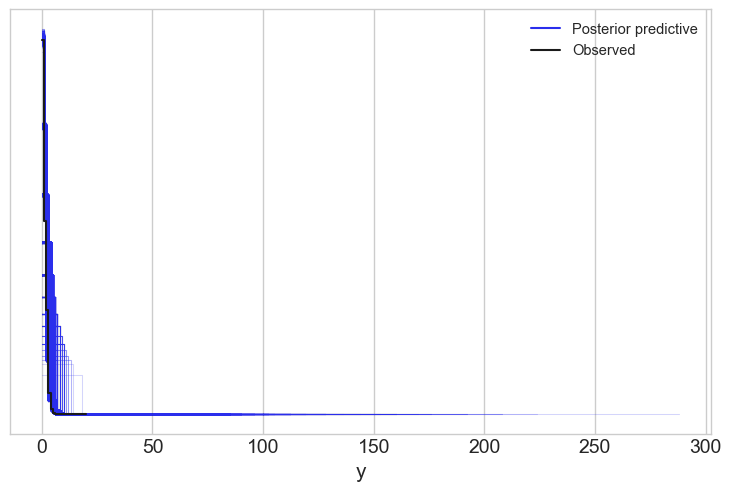

In [38]:
az.plot_ppc(idata_aux, mean = False)

In [37]:
az.summary(trace_glm_nb)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.351,0.010,-0.371,-0.334,0.000,0.000,4081.0,3137.0,1.0
DIG_IMPS,-1.015,0.201,-1.402,-0.668,0.003,0.003,3861.0,2370.0,1.0
TV_IMPS,0.001,0.000,0.001,0.001,0.000,0.000,3873.0,3109.0,1.0
mu,66.995,797.732,0.001,101.834,15.399,10.890,4030.0,1973.0,1.0
alpha,1.998,0.074,1.863,2.136,0.001,0.001,3894.0,3055.0,1.0


### NegativeBinomial as Likelihood

In [57]:
with pm.Model() as model_negative_binomial:

        # Intercept
        alpha = pm.Normal('alpha', mu=y.mean(), sd=10)

        # Slope
        beta = pm.HalfFlat('beta', shape = len(data.columns[:-1]))

        # Error term
        eps = pm.HalfCauchy('eps', 5)

        # Expected value of outcome (ML Regression with vectors)
        mu = alpha + pm.math.dot(x, beta)

        # Likelihood
        conv = pm.NegativeBinomial('conv', 
                                   mu = mu, 
                                   alpha= eps,  
                                   observed=y)

        trace_negative_binomial = pm.sample(chains = 4, target_accept = 0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [eps, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 520 seconds.


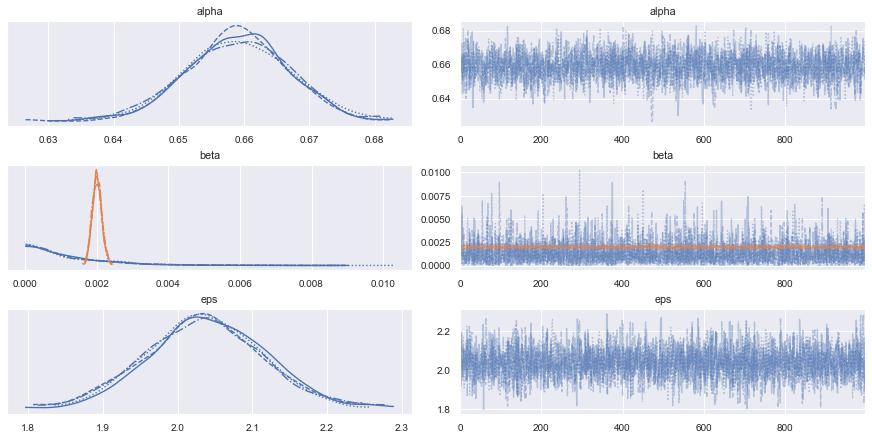

In [58]:
az.plot_trace(trace_negative_binomial)
plt.show()

posterior predictive variable conv's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


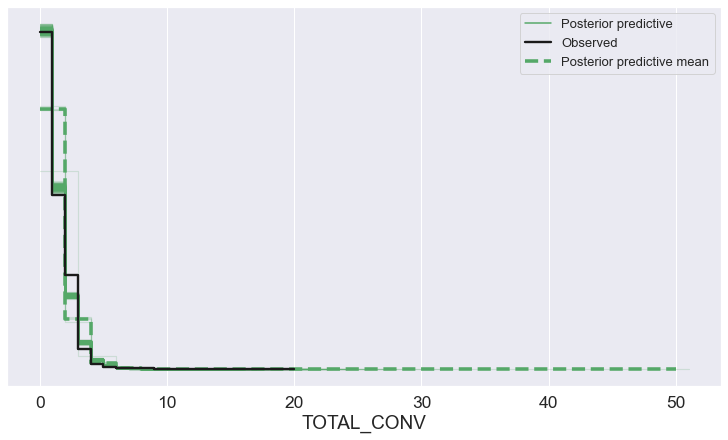

R2 for Model is : 0.047


In [59]:
predictions_negative_binomial = ppc_check(model = model_negative_binomial, 
                            data = data, 
                            trace = trace_negative_binomial, 
                            predictions= True)

### ZeroInflated Poisson as Likelihood

In [7]:
with pm.Model() as model_zip:

        # Intercept
        alpha = pm.Normal('alpha', mu=y.mean(), sd=10)

        # Slope
        beta = pm.HalfFlat('beta', shape = len(data.columns[:-1]))

#         # Error term
#         eps = pm.HalfCauchy('eps', 5)
        psi = pm.Beta('psi', 1, 1)
        # BoundedFlat = pm.Bound(pm.Flat, lower=0.0, upper = 1.0)
        # psi = BoundedFlat('psi')
        
        # Expected value of outcome (ML Regression with vectors)
        mu = alpha + pm.math.dot(x, beta)

        # Likelihood
        conv = pm.ZeroInflatedPoisson('conv', 
                                      theta= mu, 
                                      psi= psi,  
                                      observed=y)

        trace_zip = pm.sample(chains = 4, target_accept = 0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [psi, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 800 seconds.


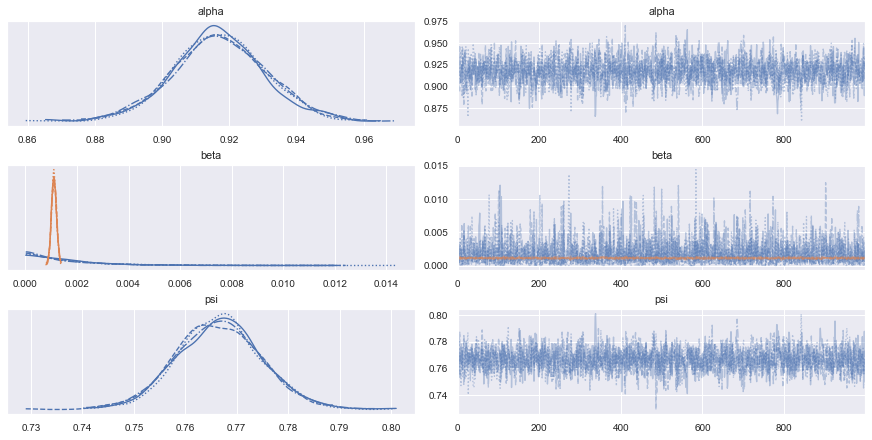

In [8]:
az.plot_trace(trace_zip)
plt.show()

posterior predictive variable conv's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


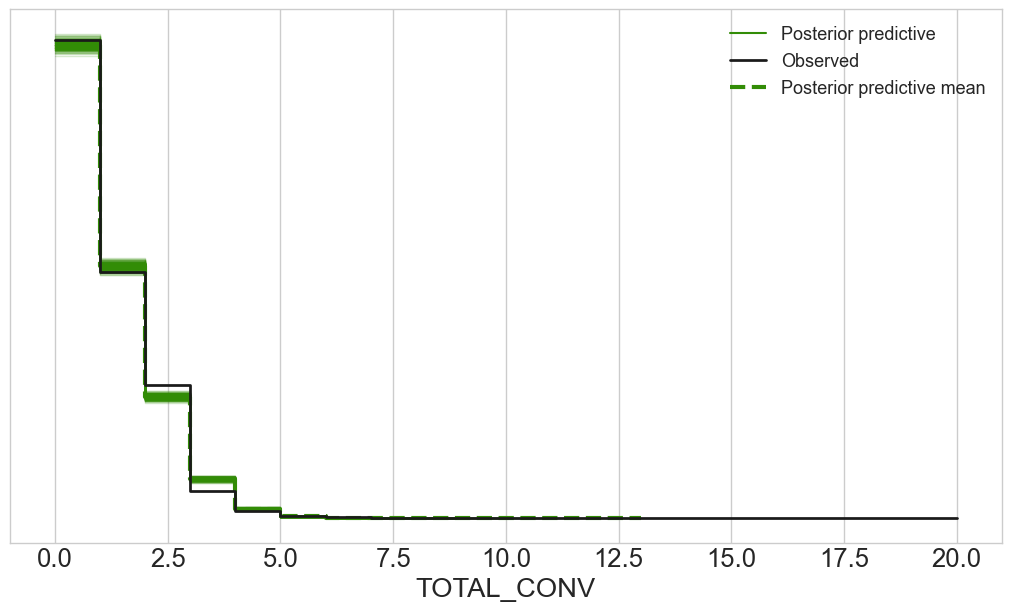

R2 for Model is : 0.014


In [99]:
predictions_zip = ppc_check(model=model_zip, 
                            data = data, 
                            trace= trace_zip, 
                            samples_n=200,
                            predictions= True)

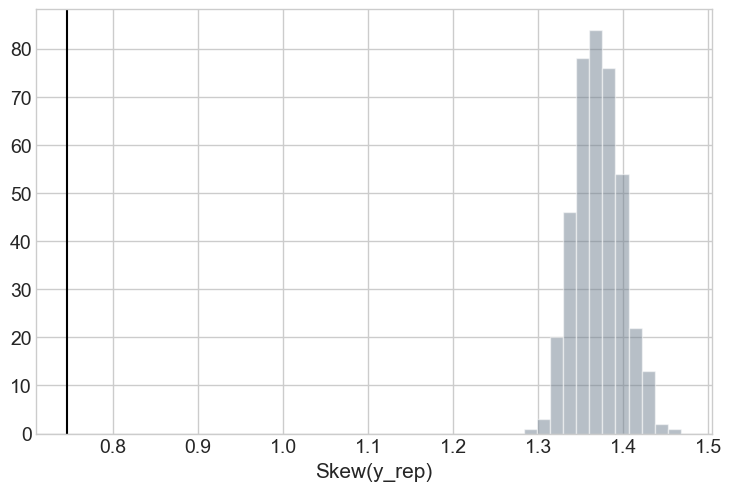

In [80]:
def skew(y):
    '''Compute Fisher-Pearson skew coefficient for values of y'''
    n = len(y)
    dif = y - y.mean()
    skew_stat = (np.sqrt(n-1)/(n-2))*n*(np.sum(dif**3)/(np.sum(dif**2)**1.5))
    return skew_stat
    
# Get 1000 posterior samples -------
ppc_rint = predictions_zip
 
# Plot observed and simulated skewness ----------                                        
plt.style.use("arviz-whitegrid")
plt.hist([skew(y) for y in ppc_rint['conv']], 
         bins=12, alpha=0.5, color='slategray')
plt.axvline(y.mean(), color='black')
plt.xlabel('Skew(y_rep)')
plt.show()

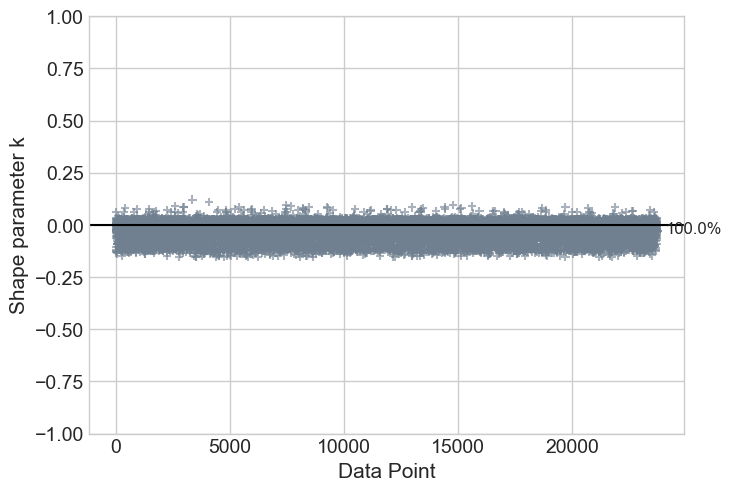

In [100]:
# compute with arviz InferenceData type
pw_rint_loo = pm.loo(trace_zip, pointwise=True, var_name='conv')

# plot khat diagnostic
plt.style.use("arviz-whitegrid")
pm.plot_khat(pw_rint_loo, show_bins=True, color='slategray', alpha=0.6)
plt.axhline(0, color='black')
plt.ylim((-1, 1))
plt.show()

In [101]:
pd.DataFrame(pw_rint_loo)

,0
loo,-28321.173282
loo_se,196.333629
p_loo,4.217678
n_samples,4000
n_data_points,23745
warning,False
loo_i,[<xarray.DataArray 'loo_i' ()>\narray(-8.27918...
pareto_k,[<xarray.DataArray 'pareto_shape' ()>\narray(0...
loo_scale,log


In [105]:
pw_rint_loo

Computed from 4000 by 23745 log-likelihood matrix

         Estimate       SE
elpd_loo -28321.17   196.33
p_loo        4.22        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     23745  100.0%
 (0.5, 0.7]   (ok)           0    0.0%
   (0.7, 1]   (bad)          0    0.0%
   (1, Inf)   (very bad)     0    0.0%

In [111]:
[v for v in pw_rint_loo.pareto_k.values if v>0.5]

[]

In [98]:
# comparing each sample-prediction distribution to observed data and collecting p-value for each sample

p_values = []
for sample in predictions_zip['conv']:
    p_values.append(ks_2samp(y, sample).pvalue)

In [62]:
# Checking p-values that > 0.05 (5%)

print('Number of samples with p-value grater then 0.05 is : {}'.format(len([v for v in p_values if v>=0.05])))
# [v for v in p_values if v>=0.05]

Number of samples with p-value grater then 0.05 is : 117


### ZeroInflatedNegativeBinomial for Likelihood Function

In [64]:
data_mod = data[data['TOTAL_CONV']>0]
x_mod,y_mod = data_mod.iloc[:,:-1].values, data_mod.TOTAL_CONV

In [65]:
with pm.Model() as model_zinb:

        # Intercept
        alpha = pm.Normal('alpha', mu=y.mean(), sd=10)

        # Slope
        beta = pm.HalfFlat('beta', shape = len(data.columns[:-1]))

        # Error term
        eps = pm.Gamma('eps', 1, 0.5)
        
        psi = pm.Beta('psi', 1, 1)

        # Expected value of outcome (ML Regression with vectors)
        mu = alpha + pm.math.dot(x, beta)
        
        conv = pm.ZeroInflatedNegativeBinomial('conv', 
                                              mu = mu,
                                              psi = psi,
                                              alpha = eps,
                                              observed = y)
        
        trace_zinb = pm.sample(chains = 4, target_accept = 0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [psi, eps, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1559 seconds.


### Using Constrain on ZeroInflatedNegativeBinomial Likelihood

In [67]:
with pm.Model() as model_zinb_constrained:

        # Intercept
        alpha = pm.Normal('alpha', mu=y.mean(), sd=10)

        # Slope
        beta = pm.HalfFlat('beta', shape = len(data.columns[:-1]))

        # Error term
        eps = pm.Gamma('eps', 1, 0.5)
        
        psi = pm.Beta('psi', 1, 1)

        # Expected value of outcome (ML Regression with vectors)
        mu = alpha + pm.math.dot(x, beta)
        
        conv = pm.ZeroInflatedNegativeBinomial('conv', 
                                              mu = mu,
                                              psi = psi,
                                              alpha = eps,
                                              observed = y)
        
        pm.Potential('constraint', tt.switch(conv > y.max(), -np.inf, 0.))
        
        trace_zinb_constrained = pm.sample(chains = 4, target_accept = 0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [psi, eps, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 907 seconds.


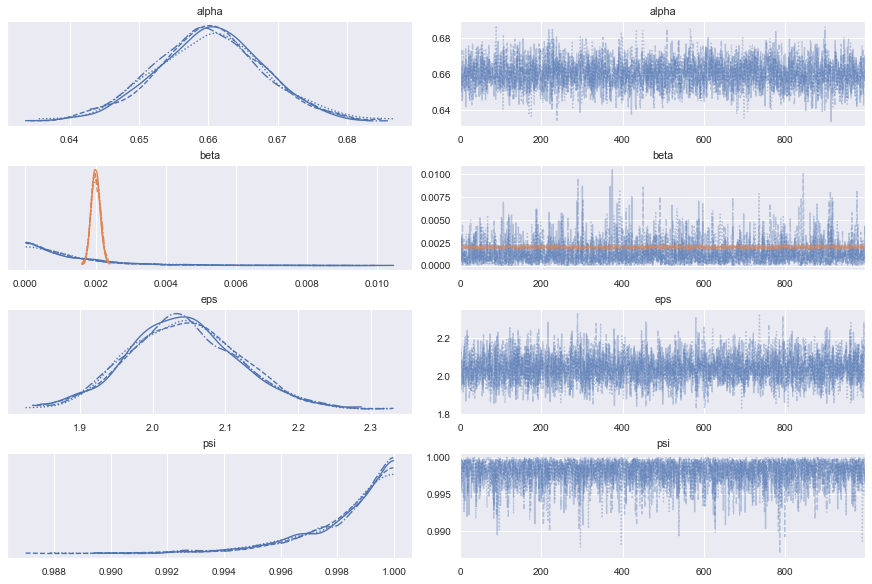

In [68]:
az.plot_trace(trace_zinb_constrained)
plt.show()

posterior predictive variable conv's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


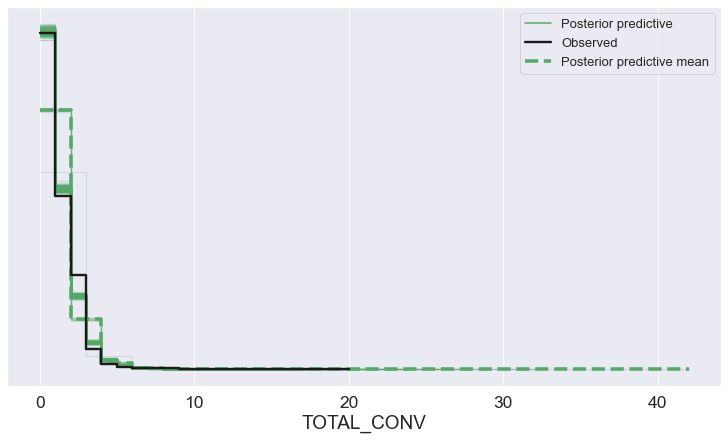

R2 for Model is : 0.048


In [69]:
predictions_zinb_constrained = ppc_check(model=model_zinb_constrained, 
                            data = data, 
                            trace= trace_zinb_constrained, 
                            predictions= True)

posterior predictive variable conv's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


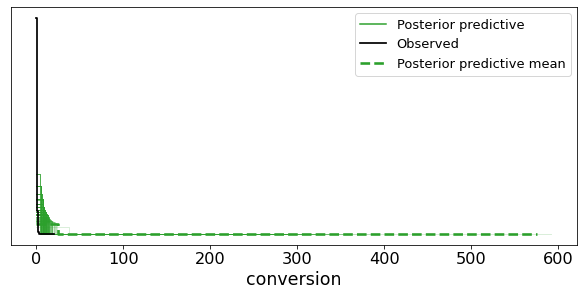

R2 for Model is : 0.806


In [30]:
predictions_zinb_constrained = ppc_check(model=model_zinb_constrained, 
                            data = data, 
                            trace= trace_zinb_constrained, 
                            predictions= True)

posterior predictive variable conv's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


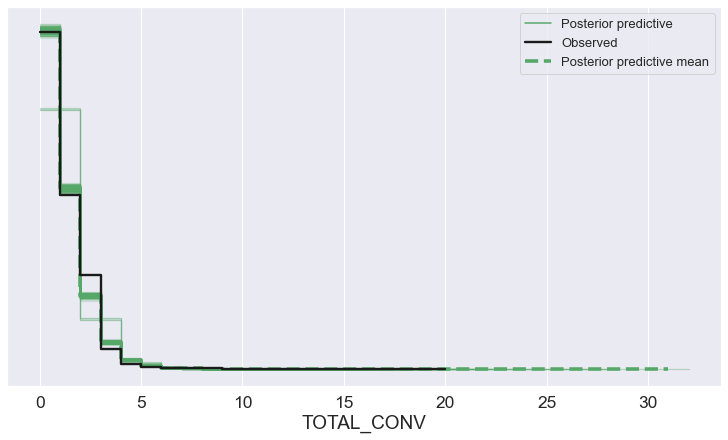

R2 for Model is : 0.048


In [66]:
predictions_zinb = ppc_check(model=model_zinb, 
                            data = data, 
                            trace= trace_zinb, 
                            predictions= True)

### Model Comparison

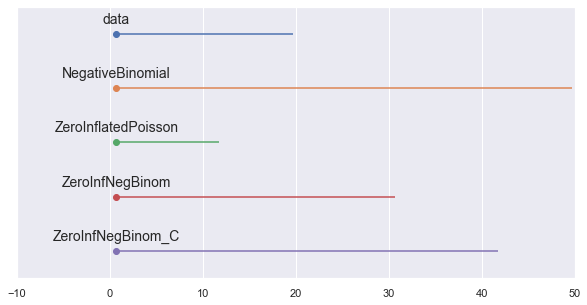

In [74]:
plt.figure(figsize=(10, 5))
ppc_data = [y, 
            predictions_negative_binomial['conv'], 
            predictions_zip['conv'],
            predictions_zinb['conv'], 
            predictions_zinb_constrained['conv'],            
           ]

labels = ['data', 
          'NegativeBinomial', 
          'ZeroInflatedPoisson', 
          'ZeroInfNegBinom', 
          'ZeroInfNegBinom_C']
for i, d in enumerate(ppc_data):
    mean = d.mean()
    err = np.percentile(d, [0, 100])
    plt.errorbar(mean, -i, xerr=[[-err[0]], [err[1]]], fmt='o')
    plt.text(mean, -i+0.2, labels[i], ha='center', fontsize=14)
    plt.ylim([-i-0.5, 0.5])
    plt.xlim([-10, 50])
    plt.yticks([])

In [71]:
cmp_df = az.compare({'NegativeBinomial':trace_negative_binomial, 
                     'ZeroInflatedPoisson':trace_zip,
                     'ZeroInfNegBinom':trace_zinb,
                     'ZeroInfNegBinom_C':trace_zinb_constrained}, 
                   # method='BB-pseudo-BMA'
                   )
cmp_df

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
NegativeBinomial,0,-27891.684600,4.588951,0.000000,9.929046e-01,157.101036,0.000000,False,log
ZeroInfNegBinom_C,1,-27892.429129,4.198578,0.744529,1.868491e-14,157.078376,0.099851,False,log
ZeroInfNegBinom,2,-27892.502307,4.361672,0.817707,1.542695e-14,157.123443,0.083464,False,log
ZeroInflatedPoisson,3,-28321.173282,4.217678,429.488681,7.095382e-03,196.333629,57.938749,False,log


In [93]:
pd.DataFrame(pw_rint_loo).T

,loo,loo_se,p_loo,n_samples,n_data_points,warning,loo_i,pareto_k,loo_scale
0,-28321.173282,196.333629,4.217678,4000,23745,False,[<xarray.DataArray 'loo_i' ()>\narray(-8.27918...,[<xarray.DataArray 'pareto_shape' ()>\narray(0...,log


In [95]:
pw_rint_loo['pareto_k']

<xarray.DataArray 'pareto_shape' (conv_dim_0: 23745)>
array([ 0.00643467, -0.0226592 , -0.02304423, ..., -0.02569701,
       -0.03037673, -0.02686841])
Coordinates:
  * conv_dim_0  (conv_dim_0) int32 0 1 2 3 4 5 ... 23740 23741 23742 23743 23744

The index is the names of the models taken from the keys of the dictionary passed to compare(.).

rank, the ranking of the models starting from 0 (best model) to the number of models.

loo, the values of LOO (or WAIC). The DataFrame is always sorted from best LOO/WAIC to worst.

p_loo, the value of the penalization term. We can roughly think of this value as the estimated effective number of parameters (but do not take that too seriously).

d_loo, the relative difference between the value of LOO/WAIC for the top-ranked model and the value of LOO/WAIC for each model. For this reason we will always get a value of 0 for the first model.

weight, the weights assigned to each model. These weights can be loosely interpreted as the probability of each model being true (among the compared models) given the data.

se, the standard error for the LOO/WAIC computations. The standard error can be useful to assess the uncertainty of the LOO/WAIC estimates. By default these errors are computed using stacking.

dse, the standard errors of the difference between two values of LOO/WAIC. The same way that we can compute the standard error for each value of LOO/WAIC, we can compute the standard error of the differences between two values of LOO/WAIC. Notice that both quantities are not necessarily the same, the reason is that the uncertainty about LOO/WAIC is correlated between models. This quantity is always 0 for the top-ranked model.

warning, If True the computation of LOO/WAIC may not be reliable.

loo_scale, the scale of the reported values. The default is the log scale as previously mentioned. Other options are deviance – this is the log-score multiplied by -2 (this reverts the order: a lower LOO/WAIC will be better) – and negative-log – this is the log-score multiplied by -1 (as with the deviance scale, a lower value is better).

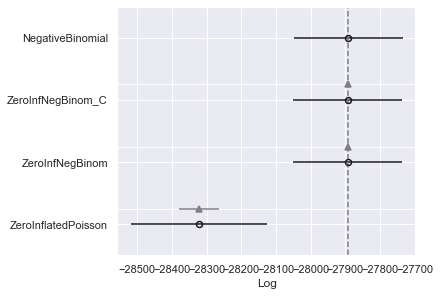

In [72]:
az.plot_compare(cmp_df, insample_dev=False)
plt.show()

The empty circle represents the values of LOO and the black error bars associated with them are the values of the standard deviation of LOO.

The value of the highest LOO, i.e the best estimated model, is also indicated with a vertical dashed grey line to ease comparison with other LOO values.

For all models except the top-ranked one we also get a triangle indicating the value of the difference of WAIC between that model and the top model and a grey errobar indicating the standard error of the differences between the top-ranked WAIC and WAIC for each model.

In [ ]:
coeff_nb = az.summary(trace_negative_binomial, 
                      var_names='beta').set_index(data.columns[:-1]).rename(columns={'mean':'NegBinomial_Coeff'})['NegBinomial_Coeff']

In [ ]:
coeff_zinb = az.summary(trace_zinb, 
                        var_names='beta').set_index(data.columns[:-1]).rename(columns={'mean':'ZeroInfNB_Coeff'})['ZeroInfNB_Coeff']

In [ ]:
pd.concat([coeff_nb, coeff_zinb], axis = 1)

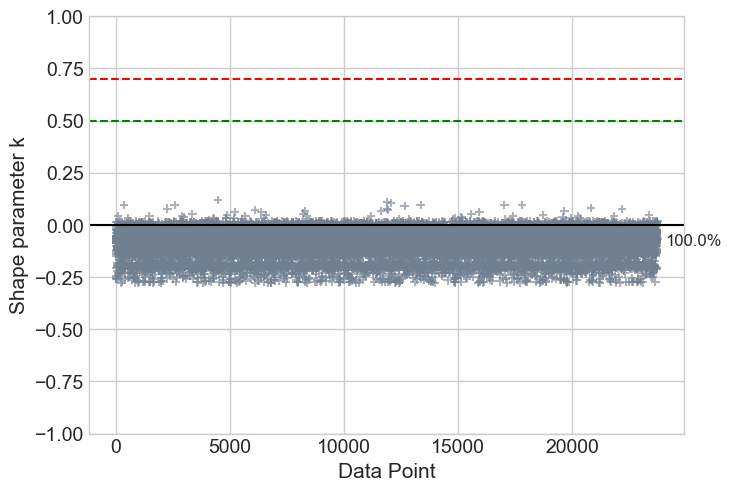

In [114]:
# compute with arviz InferenceData type
pw_rint_loo_nb = pm.loo(trace_negative_binomial, pointwise=True, var_name='conv')

# plot khat diagnostic
plt.style.use("arviz-whitegrid")
pm.plot_khat(pw_rint_loo_nb, show_bins=True, color='slategray', alpha=0.6)
plt.axhline(0.5, color = 'green', linestyle='dashed')
plt.axhline(0.7, color = 'red', linestyle='dashed')
plt.axhline(0, color='black')
plt.ylim((-1, 1))
plt.show()

In [115]:
coeff_nb = az.summary(trace_negative_binomial, 
                      var_names='beta').set_index(data.columns[:-1]).rename(columns={'mean':'NegBinomial_Coeff'})['NegBinomial_Coeff']

In [119]:
coeff_zip = az.summary(trace_zip, 
                       var_names='beta').set_index(data.columns[:-1]).rename(columns={'mean':'ZIP_Coeff'})['ZIP_Coeff']

In [120]:
pd.concat([coeff_nb,coeff_zip], axis = 1)

,NegBinomial_Coeff,ZIP_Coeff
DIG_IMPS,0.001,0.002
TV_IMPS,0.002,0.001
